In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [24]:
import torch
import torchvision
from torchvision import transforms
# from datasets import load_from_disk
# from transformers import AutoTokenizer

import os
import itertools
import json
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import scipy.stats as stats
import math

In [3]:
from torch_spotlight.datasets import *
from torch_spotlight.utils import *
from torch_spotlight.plot_utils import *

setupPlots()

In [7]:
# on our cluster, use tmpdir for data
os.environ['DATA_DIR'] = os.environ['TMPDIR']

In [8]:
data_dir = os.environ['DATA_DIR'] 
fairface_dir = os.path.join(data_dir, 'fairface')
imagenet_dir = os.path.join(data_dir, 'imagenet')
xray_dir = os.path.join(data_dir, 'xray')
ml_100k_dir = os.path.join(data_dir, 'movielens/ml-100k')

# FairFace

## Dataset

In [9]:
fairface_val = FairFace(
    fairface_dir,
    train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ])
)
print(len(fairface_val))
fairface_val.age

10954


array([1, 6, 4, ..., 7, 3, 5])

In [10]:
fairface_labels = [fairface_val[i][2] for i in range(2000)]

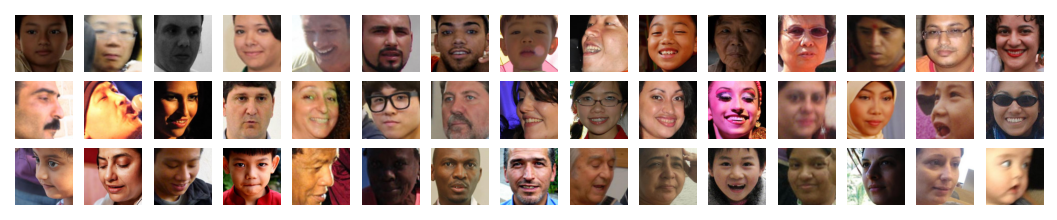

In [12]:
examples = [fairface_val[i] for i in range(18*4)]
images = [example[0] for example in examples]
titles = ['Female' if example[2] else 'Male' for example in examples]
titles = ['' for example in examples]
plotImageGrid((7, 1.4), (15, 3), images, titles)
plt.savefig('figures/fairface_val_random.png')

## Model outputs

In [16]:
inf_results = loadResults(
    'inference_results/fairface_val_resnet.pkl',
)
losses = inf_results.losses
embeddings = inf_results.embeddings
outputs = inf_results.outputs

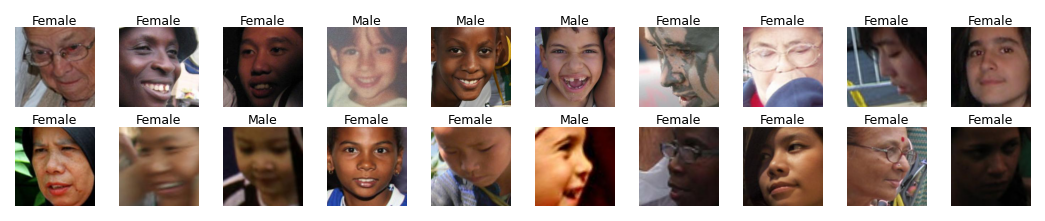

In [17]:
loss_idx = losses.argsort(descending = True)
examples = [fairface_val[i] for i in loss_idx[:100]]
images = [example[0] for example in examples]
example_losses = [losses[i] for i in loss_idx[:100]]
titles = [('Female' if example[2] else 'Male') + (' (%.3f)' % example_losses[i]) for (i, example) in enumerate(examples)]
titles = [('Female' if example[2] else 'Male') for (i, example) in enumerate(examples)]
plotImageGrid((7, 1.4), (10, 2), images, titles)
plt.savefig('figures/fairface_val_loss.png')

## Spotlights

In [21]:
spotlights = {}
for count in np.arange(1, 6):
    spotlights[count] = loadResults(f'spotlight_results/fairface_val_resnet_0.02_spherical_{count}.pkl')

In [22]:
def plotHighWeightImages(spotlight, figname=None):
    weights = spotlight.unnormalized_weights
    weight_idx = weights.argsort()[::-1]
    examples = [fairface_val[i] for i in weight_idx[:30]]
    example_losses = [losses[i] for i in weight_idx[:30]]
    images = [example[0] for example in examples]
    titles = [('Female' if example[2] else 'Male') for (i, example) in enumerate(examples)]

    plotImageGrid((7, 1.4), (10, 2), images, titles, )
    if figname is not None:
        plt.savefig(f'figures/{figname}')
    plt.show()

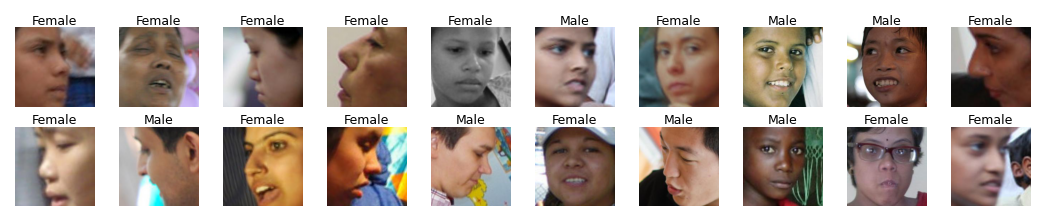

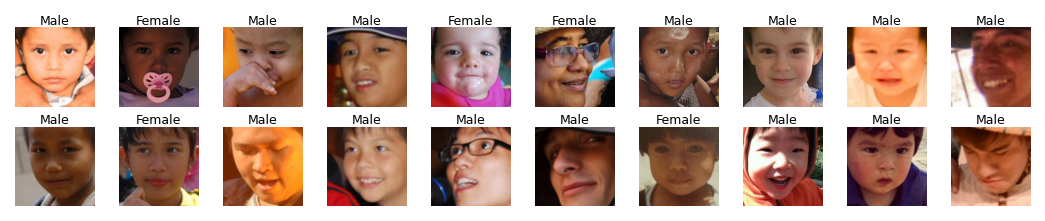

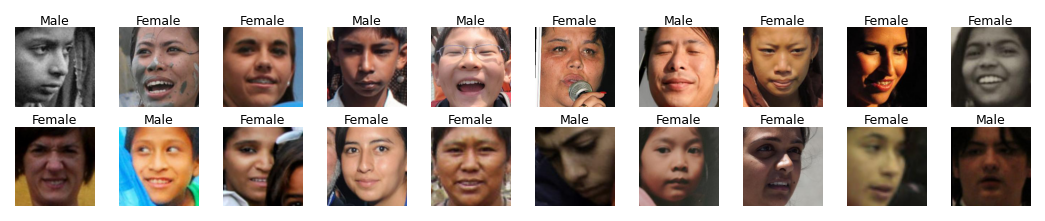

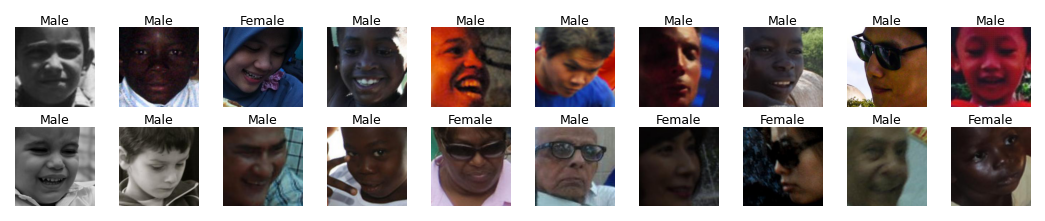

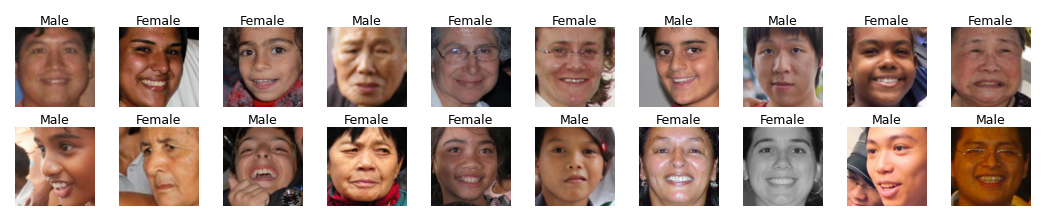

In [23]:
plotHighWeightImages(spotlights[1], 'fairface_val_1.png')
plotHighWeightImages(spotlights[2], 'fairface_val_2.png')
plotHighWeightImages(spotlights[3], 'fairface_val_3.png')
plotHighWeightImages(spotlights[4], 'fairface_val_4.png')
plotHighWeightImages(spotlights[5], 'fairface_val_5.png')

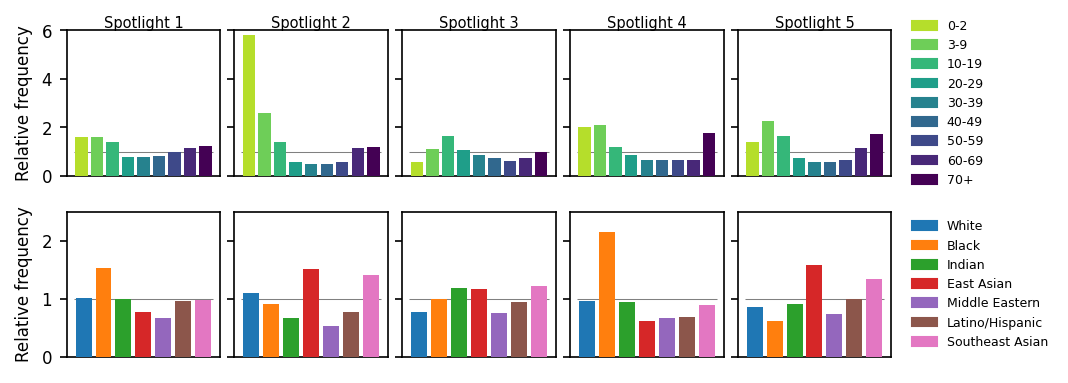

In [25]:
# plot demographics
fig, ax_list = plt.subplots(2, 5, figsize=(7, 2.5))

# ages
age_dists = [None for _ in range(6)]
age_ratios = [None for _ in range(6)]
age_dists[0] = np.array([(fairface_val.age == i).sum() / len(fairface_val) for i in range(len(fairface_val.age_classes))])
for k in spotlights:
    age_dists[k] = np.array([spotlights[k].weights@(fairface_val.age == i) for i in range(len(fairface_val.age_classes))])
    age_ratios[k] = age_dists[k] / age_dists[0]
age_colors = [plt.cm.viridis_r((i+1)/9) for i in range(len(fairface_val.age_classes))]

for col in range(5):
    ax_list[0, col].bar(fairface_val.age_classes, age_ratios[col+1], zorder=4, color=age_colors)
    ax_list[0, col].set_ylim(0, 6)
    ax_list[0, col].hlines([1], -0.5, 8.5, edgecolor='gray', linewidth=0.5)
    ax_list[0, col].set_title('Spotlight %d' % (col+1), fontsize=7)
    ax_list[0, col].set_xticks([])
    ax_list[0, col].set_yticks([0, 2, 4, 6])
    if col == 0:
        ax_list[0, col].set_ylabel('Relative frequency')
    if col != 0:
        ax_list[0, col].set_yticklabels([])
        
age_names = fairface_val.age_classes.copy()
age_names[-1] = '70+' 
age_patches = [Patch(color=age_colors[i], label=age_names[i]) for i in range(len(fairface_val.age_classes))]
ax_list[0, -1].legend(
    labels=age_names, 
    handles=age_patches, 
    bbox_to_anchor=(1.1, 0.5), 
    loc='center left', borderaxespad=0, 
    fontsize=6,
    frameon=False
)
  
# races
race_dists = [None for _ in range(6)]
race_ratios = [None for _ in range(6)]
race_dists[0] = np.array([(fairface_val.race == i).sum() / len(fairface_val) for i in range(len(fairface_val.race_classes))])
for k in spotlights:
    race_dists[k] = np.array([spotlights[k].weights @ (fairface_val.race == i) for i in range(len(fairface_val.race_classes))])
    race_ratios[k] = race_dists[k] / race_dists[0]
race_colors = [plt.cm.tab10(i) for i in range(len(fairface_val.race_classes))]

for col in range(5):
    ax_list[1, col].bar(fairface_val.race_classes, race_ratios[col+1], zorder=4, color=race_colors)
    ax_list[1, col].set_ylim(0, 2.5)
    ax_list[1, col].hlines([1], -0.5, 6.5, edgecolor='gray', linewidth=0.5)
    ax_list[1, col].set_xticks([])
    ax_list[1, col].set_yticks([0, 1, 2])
    if col == 0:
        ax_list[1, col].set_ylabel('Relative frequency')
    if col != 0:
        ax_list[1, col].set_yticklabels([])
    
race_names = fairface_val.race_classes.copy()
race_names[-2] = 'Latino/Hispanic'
race_patches = [Patch(color=race_colors[i], label=race_names[i]) for i in range(len(fairface_val.race_classes))]
ax_list[1, -1].legend(
    labels=race_names, 
    handles=race_patches, 
    bbox_to_anchor=(1.1, 0.5), 
    loc='center left', borderaxespad=0, 
    fontsize=6,
    frameon=False
)


fig.tight_layout(pad=0.4)
plt.savefig('figures/fairface_demographics.png', bbox_inches='tight', pad_inches=0.01)

# ImageNet

## Dataset

In [39]:
imagenet = torchvision.datasets.ImageNet(
    root=imagenet_dir, 
    split='val',
    transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]))

In [29]:
# For image captions, shorten a few long labels 
synset_changes = {
    'leatherback turtle': 'leatherback',
    'African hunting dog': 'hunting dog',
    'Chesapeake Bay retriever': 'Chessie',
    'Bouvier des Flandres': 'Bouvier',
    'Kerry blue terrier': 'blue terrier',
    'American Staffordshire terrier': 'American terrier',
    'curly-coated retriever': 'Curly retriever',
}

In [30]:
with open('torch_spotlight/imagenet_synsets.txt') as f:
    synset_strings = '\n'.join(f.readlines())
synset_lookup = eval(synset_strings)

imagenet_labels = []
for i in range(1000):
    synset_label = synset_lookup[i]['label'].split(',')[0]
    if synset_label in synset_changes:
        synset_label = synset_changes[synset_label]
    imagenet_labels += [synset_label] * 50

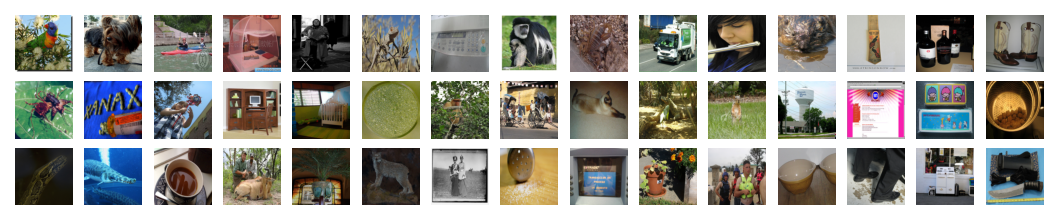

In [31]:
np.random.seed(0)
random_idx = np.random.permutation(len(imagenet))
examples = [imagenet[random_idx[i]] for i in range(100)]
images = [example[0] for example in examples]
titles = ['' for example in examples]
plotImageGrid((7, 1.4), (15, 3), images, titles)
plt.savefig('figures/imagenet_val_random.png')

## Model outputs

In [32]:
inf_results = loadResults(
    os.path.join(os.getcwd(), 'inference_results/imagenet_val_resnet.pkl'),
)

losses = inf_results.losses
embeddings = inf_results.embeddings
outputs = inf_results.outputs

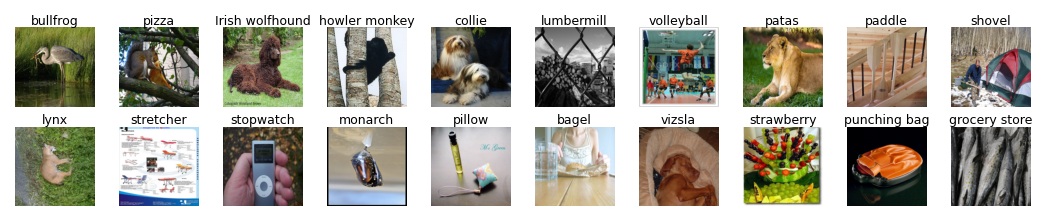

In [41]:
loss_idx = losses.argsort(descending=True)
examples = [imagenet[i] for i in loss_idx[:100]]
images = [example[0] for example in examples]
example_losses = [losses[i] for i in loss_idx[:100]]
titles = [imagenet_labels[loss_idx[i]] for (i, example) in enumerate(examples)]
plotImageGrid((7, 1.4), (10, 2), images, titles)
plt.savefig('figures/imagenet_val_loss.png')

## Spotlights

In [43]:
spotlights = {}
for count in np.arange(1, 6):
    spotlights[count] = loadResults(f'spotlight_results/imagenet_val_resnet_0.02_spherical_{count}.pkl')

In [44]:
def plotSpotlightsImagenet(spotlight, figname=None):
    weights = spotlight.weights
    weight_idx = weights.argsort()[::-1]
    examples = [imagenet[i] for i in weight_idx[:100]]
    example_losses = [losses[i] for i in weight_idx[:100]]
    images = [example[0] for example in examples]
    titles = [imagenet_labels[i] for i in weight_idx[:100]]

    plotImageGrid((7, 1.4), (10, 2), images, titles, )
    if figname is not None:
        plt.savefig(f'figures/{figname}')
    plt.show()

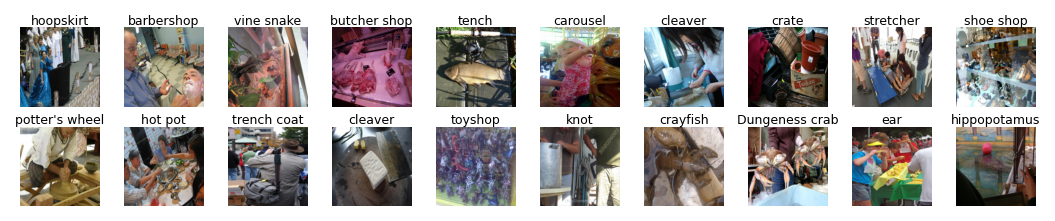

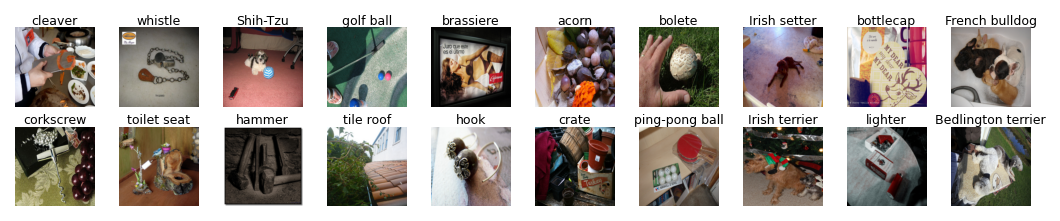

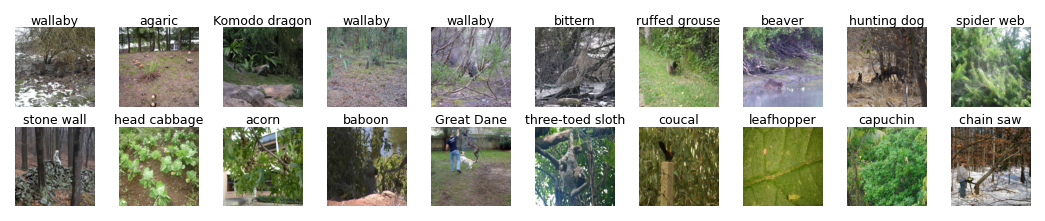

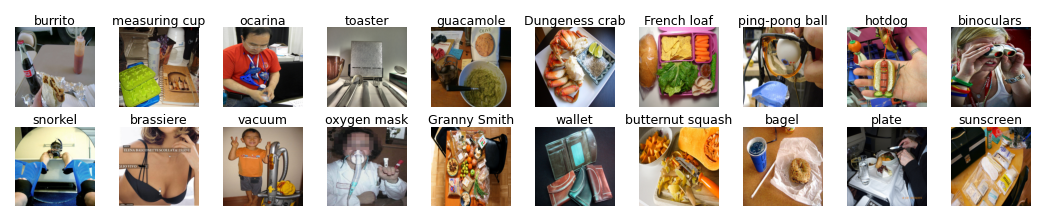

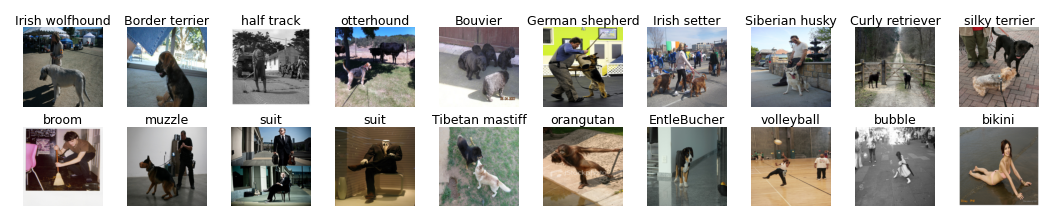

In [45]:
plotSpotlightsImagenet(spotlights[1], 'imagenet_val_1.png')
plotSpotlightsImagenet(spotlights[2], 'imagenet_val_2.png')
plotSpotlightsImagenet(spotlights[3], 'imagenet_val_3.png')
plotSpotlightsImagenet(spotlights[4], 'imagenet_val_4.png')
plotSpotlightsImagenet(spotlights[5], 'imagenet_val_5.png')

# X-ray

## Dataset

In [84]:
xray_train = ChestXRay(
    xray_dir,
    train=True,
    transform=transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((150,150)),
        transforms.ToTensor(),
    ]))

In [85]:
xray_labels = np.array([xray_train[i][1] for i in range(len(xray_train))])

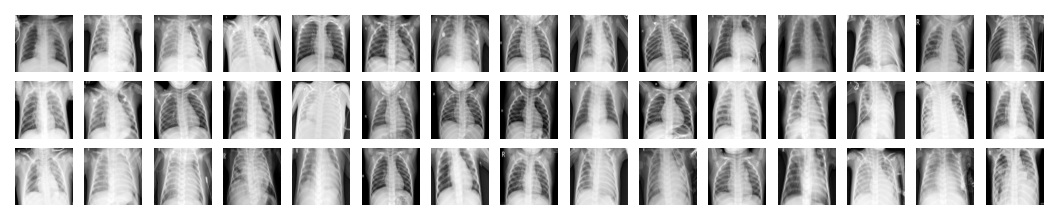

In [86]:
np.random.seed(0)
random_idx = np.random.permutation(len(xray_train))
examples = [xray_train[random_idx[i]] for i in range(100)]
images = [example[0] for example in examples]
titles = ['' for example in examples]
plotImageGrid((7, 1.4), (15, 3), images, titles, cmap='gray')
plt.savefig('figures/xray_train_random.png')

## Model outputs

In [87]:
inf_results = loadResults(
    os.path.join(os.getcwd(), 'inference_results/xray_train_cnn.pkl'),
)

losses = inf_results.losses
embeddings = inf_results.embeddings
outputs = inf_results.outputs

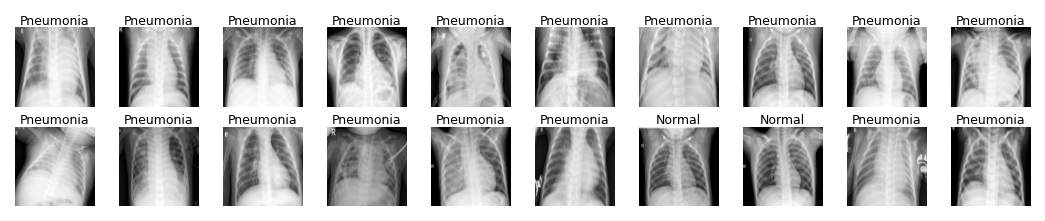

In [88]:
loss_idx = losses.argsort(descending=True)
examples = [xray_train[i] for i in loss_idx[:100]]
images = [example[0] for example in examples]
example_losses = [losses[i] for i in loss_idx[:100]]
titles = ['Pneumonia' if xray_labels[loss_idx[i]] else 'Normal' for (i, example) in enumerate(examples)]
plotImageGrid((7, 1.4), (10, 2), images, titles, cmap='gray')
plt.savefig('figures/xray_train_loss.png')

## Spotlights

In [89]:
spotlights = {}
for count in np.arange(1, 6):
    spotlights[count] = loadResults(f'spotlight_results/xray_train_resnet_0.02_spherical_{count}.pkl')

In [95]:
def plotSpotlightsXray(spotlight, figname=None):
    weights = spotlight.weights
    weight_idx = weights.argsort()[::-1]
    examples = [xray_train[i] for i in weight_idx[:100]]
    example_losses = [losses[i] for i in weight_idx[:100]]
    images = [example[0] for example in examples]
    titles = ['Pneumonia' if xray_labels[weight_idx[i]] else 'Normal' for (i, example) in enumerate(examples)]

    plotImageGrid((7, 1.4), (10, 2), images, titles, cmap='gray')
    if figname is not None:
        plt.savefig(f'figures/{figname}')
    plt.show()

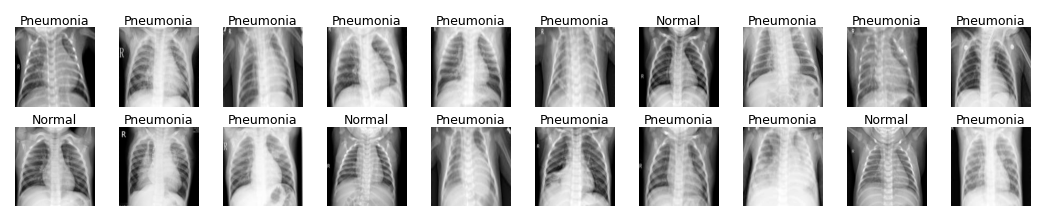

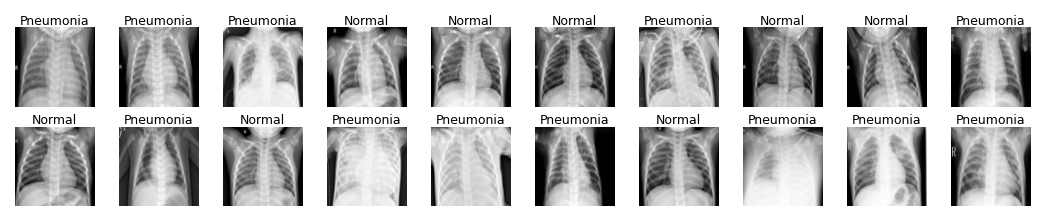

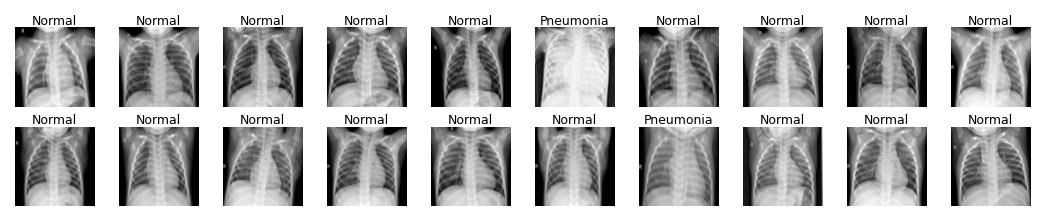

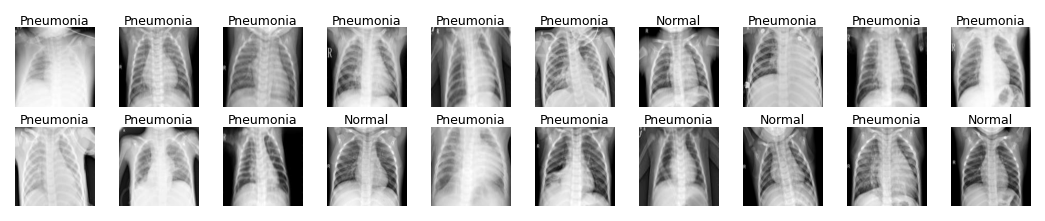

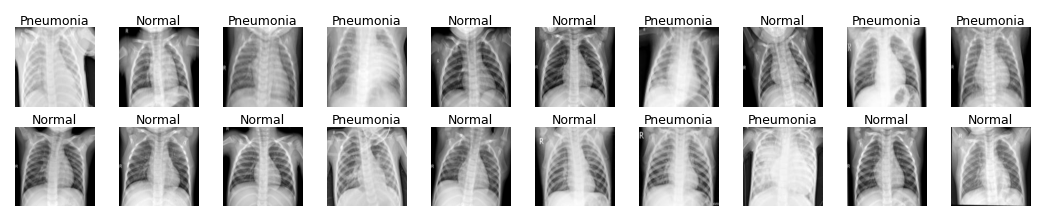

In [96]:
plotSpotlightsXray(spotlights[1], 'xray_train_1.png')
plotSpotlightsXray(spotlights[2], 'xray_train_2.png')
plotSpotlightsXray(spotlights[3], 'xray_train_3.png')
plotSpotlightsXray(spotlights[4], 'xray_train_4.png')
plotSpotlightsXray(spotlights[5], 'xray_train_5.png')

# MovieLens

## Model outputs

In [60]:
inf_results = loadResults(
    os.path.join(os.getcwd(), 'inference_results/movielens_val_deepset.pkl'),
)
losses = inf_results.losses
embeddings = inf_results.embeddings
outputs = inf_results.outputs

## Dataset

In [61]:
def get_genre(row):
    ret = []
    for c in movie_df.columns:
        if row[c]==1:
            ret.append(c)
    return ret[0]


def compressMean(row):
    return '%.1f (%d)' % (row['review_mean'], row['num_reviews'])

def compressUser(row):
    return '%d (%d)' % (row['user_id'], row['num_reviews'])

In [62]:
df = pd.read_csv(ml_100k_dir + '/u1.test', sep='\t', header=None, names=['user_id', 'movie_id', 'rating', 'unix_timestamp'])
df['prediction'] = outputs.argmax(axis=1) + 1
df['loss'] = losses
display(df.columns)
df = df.drop('unix_timestamp', axis=1)

user_df = pd.read_csv(
    ml_100k_dir + '/u.user', sep='|', header=None, names=['user_id', 'age', 'gender', 'occupation', 'zip_code']
).set_index('user_id').drop('zip_code', axis=1)

movie_genres = ['unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi','Thriller', 'War', 'Western']
movie_cols = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL'] + movie_genres
movie_df = pd.read_csv(ml_100k_dir + '/u.item', sep='|', header=None, names=movie_cols) \
    .set_index('movie_id') \
    .drop(['release_date', 'video_release_date', 'IMDb_URL'], axis=1)
movie_df['genre'] = movie_df.apply(get_genre, axis=1)

Index(['user_id', 'movie_id', 'rating', 'unix_timestamp', 'prediction',
       'loss'],
      dtype='object')

In [63]:
num_reviews = []
avg_reviews = []
stddev_reviews = []
for movie_id in movie_df.index:
    movie_reviews = df[df['movie_id'] == movie_id]
    num_reviews_movie = len(movie_reviews)
    avg_review_movie = movie_reviews.mean()['rating']
    if num_reviews_movie > 1:
        stddev_review_movie = movie_reviews.std()['rating']
    else:
        stddev_review_movie = 0
    
    num_reviews.append(num_reviews_movie)
    avg_reviews.append(avg_review_movie)
    stddev_reviews.append(stddev_review_movie)
movie_df['num_reviews'] = num_reviews
movie_df['review_mean'] = avg_reviews
movie_df['review_stddev'] = stddev_reviews
movie_df['movie_mean'] = movie_df.apply(compressMean, 'columns')

In [64]:
num_reviews = []
avg_reviews = []
stddev_reviews = []
for user_id in user_df.index:
    user_reviews = df[df['user_id'] == user_id]
    num_reviews_movie = len(user_reviews)
    avg_review_movie = user_reviews.mean()['rating']
    if num_reviews_movie > 1:
        stddev_review_movie = user_reviews.std()['rating']
    else:
        stddev_review_movie = 0
    
    num_reviews.append(num_reviews_movie)
    avg_reviews.append(avg_review_movie)
    stddev_reviews.append(stddev_review_movie)
user_df['num_reviews'] = num_reviews
user_df['review_mean'] = avg_reviews
user_df['review_stddev'] = stddev_reviews
user_df['user_id'] = user_df.index
user_df['user_summary'] = user_df.apply(compressUser, 'columns')

In [65]:
user_df

age gender     occupation  num_reviews  review_mean  review_stddev  \
user_id                                                                       
1         24      M     technician          137     3.540146       1.248615   
2         53      F          other           22     3.545455       1.100964   
3         23      M         writer           26     2.576923       1.101747   
4         24      M     technician           10     4.300000       0.823273   
5         33      F          other           84     2.785714       1.326935   
...      ...    ...            ...          ...          ...            ...   
939       26      F        student            0          NaN       0.000000   
940       32      M  administrator            0          NaN       0.000000   
941       20      M        student            0          NaN       0.000000   
942       48      F      librarian            0          NaN       0.000000   
943       22      M        student            0          NaN       0.000000   

         user_id user_summary  
user_id                        
1              1      1 (137)  
2              2       2 (22)  
3              3       3 (26)  
4              4       4 (10)  
5              5       5 (84)  
...          ...          ...  
939          939      939 (0)  
940          940      940 (0)  
941          941      941 (0)  
942          942      942 (0)  
943          943      943 (0)  

[943 rows x 8 columns]

In [76]:
full_df = df \
    .join(movie_df, on='movie_id', rsuffix='_movie') \
    .join(user_df, on='user_id', rsuffix='_user') \

## Analysis

In [66]:
pd.options.display.precision = 1

In [67]:
display_columns = ['prediction', 'rating', 'loss', 'movie_title', 'genre', 'movie_mean', 'user_summary']
pretty_names = {
    'rating': 'Rating',
    'prediction': 'Prediction',
    'loss': 'Loss',
    'movie_title': 'Movie',
    'genre': 'Genre',
#     'num_reviews': '# Reviews (movie)',
#     'review_mean': 'Mean review',
    'movie_mean': 'Avg (# Reviews)',
    'num_reviews': 'User reviews',
    'user_summary': 'User ID (# Reviews)'
}

def removeYear(title):
    return title[:-7]


def showSubset(df, order, show_first=20):
    idx = order.argsort()[::-1]
    subset_df = df.iloc[idx[:show_first]]
    subset_df = subset_df \
        .join(movie_df[['movie_title', 'genre', 'movie_mean', 'review_stddev']], on='movie_id', rsuffix='_movie') \
        .join(user_df, on='user_id', rsuffix='_user') \
        .drop('movie_id', 'columns')
#     display(subset_df)
    subset_df = subset_df[display_columns]
    
    # remove years
    subset_df['movie_title'] = subset_df['movie_title'].apply(removeYear)
    
    subset_df = subset_df.rename(columns=pretty_names)
    
    display(subset_df)
    print(subset_df.to_latex(index=False))
    


In [77]:
def getGenreDistribution(spotlight_num):
    for genre in movie_genres:
        idx = full_df[genre].values == 1
        weights = spotlights[spotlight_num].weights

        genre_df = full_df.iloc[idx]

        frac_in_spotlight = weights @ idx
        frac_in_dataset = idx.mean()
        avg_rating = (weights[idx] @ genre_df['rating'].values) / (weights[idx].sum())

        print('%.2f %.2f %.2f %.1f %s'% (frac_in_spotlight, frac_in_dataset, frac_in_spotlight/frac_in_dataset, avg_rating, genre))

In [68]:
showSubset(df, losses.numpy(), show_first=15)

Prediction  Rating  Loss                    Movie      Genre  \
14754           4       1  11.2             Pulp Fiction      Crime   
19574           4       5  11.0      Princess Bride, The     Action   
14079           5       1  10.9                 Face/Off     Action   
10439           4       1  10.5      Usual Suspects, The      Crime   
8847            4       1   8.8                    Fargo      Crime   
17534           3       5   8.7        Wizard of Oz, The  Adventure   
13972           5       1   8.1                    Alien     Action   
5048            3       1   8.0                   Mother     Comedy   
5158            4       1   7.9                Boot, Das     Action   
10803           5       1   7.9     English Patient, The      Drama   
16924           5       1   7.8            Shallow Grave   Thriller   
6679            5       1   7.8                 Face/Off     Action   
1138            4       1   7.7    Devil's Advocate, The      Crime   
16055           3       5   7.6     Addams Family Values     Comedy   
12164           5       1   7.5  Raiders of the Lost Ark     Action   

      Avg (# Reviews) User ID (# Reviews)  
14754        4.2 (82)            305 (97)  
19574        4.1 (58)             419 (3)  
14079        3.9 (42)            296 (73)  
10439        4.3 (56)           234 (202)  
8847        4.3 (113)            198 (75)  
17534        4.2 (46)             358 (8)  
13972        4.2 (68)            295 (96)  
5048         3.2 (34)            100 (25)  
5158         4.0 (35)           102 (104)  
10803        3.7 (93)            239 (73)  
16924        3.7 (14)            342 (73)  
6679         3.9 (42)           145 (131)  
1138         3.7 (31)             15 (44)  
16055        3.1 (18)            326 (74)  
12164        4.3 (76)           269 (156)

\begin{tabular}{rrrllll}
\toprule
 Prediction &  Rating &  Loss &                   Movie &     Genre & Avg (\# Reviews) & User ID (\# Reviews) \\
\midrule
          4 &       1 &  11.2 &            Pulp Fiction &     Crime &        4.2 (82) &            305 (97) \\
          4 &       5 &  11.0 &     Princess Bride, The &    Action &        4.1 (58) &             419 (3) \\
          5 &       1 &  10.9 &                Face/Off &    Action &        3.9 (42) &            296 (73) \\
          4 &       1 &  10.5 &     Usual Suspects, The &     Crime &        4.3 (56) &           234 (202) \\
          4 &       1 &   8.8 &                   Fargo &     Crime &       4.3 (113) &            198 (75) \\
          3 &       5 &   8.7 &       Wizard of Oz, The & Adventure &        4.2 (46) &             358 (8) \\
          5 &       1 &   8.1 &                   Alien &    Action &        4.2 (68) &            295 (96) \\
          3 &       1 &   8.0 &                  Mother &    Comedy

## Movie/user distributions

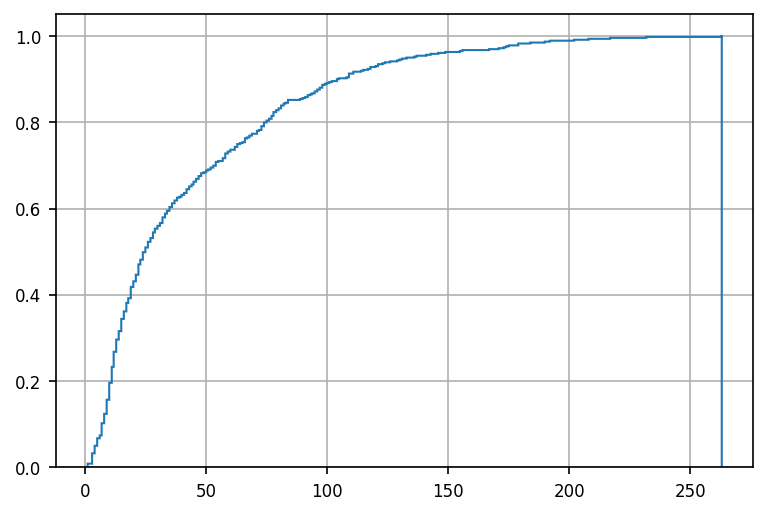

In [69]:
user_reviews = user_df.num_reviews.values
user_reviews = user_reviews[user_reviews > 0]
plt.hist(user_reviews, bins=1000, density=True, cumulative=True, histtype='step')
plt.grid()
plt.show()

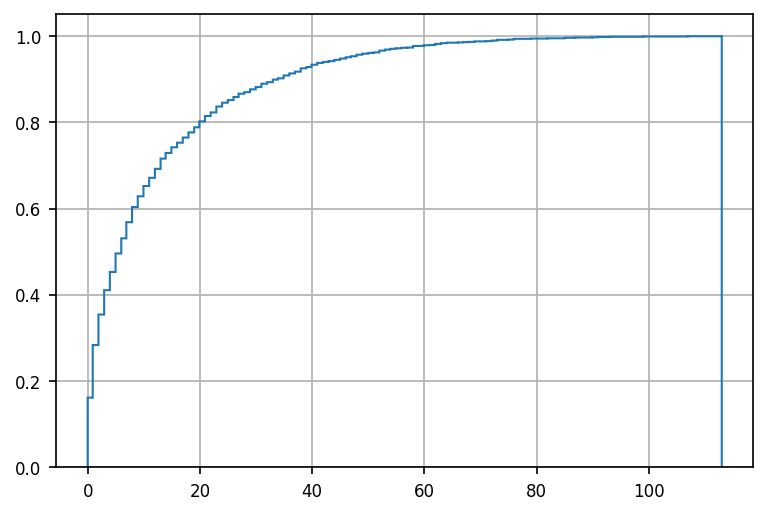

In [72]:
plt.hist(movie_df.num_reviews.values, bins=1000, density=True, cumulative=True, histtype='step')
plt.grid()
plt.show()

## Spotlights

In [73]:
spotlights = {}
counts = np.arange(1, 6)
# print(counts)
for count in counts:
    spotlights[count] = loadResults(
        os.path.join(os.getcwd(), f'spotlight_results/movielens_val_deepset_0.05_spherical_{count}.pkl'), 
    )
    

In [75]:
showSubset(df, spotlights[1].weights, 15)

Prediction  Rating  Loss                                     Movie  \
921             4       2   1.7    William Shakespeare's Romeo and Juliet   
17294           5       1   1.6                              Lost Highway   
9752            1       3   1.6                                 Crow, The   
910             4       3   1.4                                 True Lies   
8771            3       2   1.8                                 Crow, The   
17646           4       3   1.7                             Jurassic Park   
6733            5       4   1.4                             Happy Gilmore   
5338            3       3   1.2                                 Crow, The   
13293           4       1   1.3                                     Crash   
10107           4       3   1.5                             Happy Gilmore   
12240           5       5   1.0  Cook the Thief His Wife & Her Lover, The   
17296           4       4   1.1                                 True Lies   
9125            2       2   1.1    William Shakespeare's Romeo and Juliet   
869             4       4   1.2                                   Gattaca   
9753            4       5   1.5                             Jurassic Park   

         Genre Avg (# Reviews) User ID (# Reviews)  
921      Drama        3.4 (27)            13 (263)  
17294  Mystery        2.8 (26)            347 (78)  
9752    Action        3.4 (30)            217 (39)  
910     Action        3.2 (40)            13 (263)  
8771    Action        3.4 (30)            197 (66)  
17646   Action        3.6 (53)           363 (102)  
6733    Comedy        3.2 (19)           145 (131)  
5338    Action        3.4 (30)           109 (100)  
13293    Drama        2.5 (35)           286 (130)  
10107   Comedy        3.2 (19)            223 (53)  
12240    Drama        3.6 (13)           269 (156)  
17296   Action        3.2 (40)            347 (78)  
9125     Drama        3.4 (27)           201 (171)  
869      Drama        3.2 (23)            13 (263)  
9753    Action        3.6 (53)            217 (39)

\begin{tabular}{rrrllll}
\toprule
 Prediction &  Rating &  Loss &                                    Movie &   Genre & Avg (\# Reviews) & User ID (\# Reviews) \\
\midrule
          4 &       2 &   1.7 &   William Shakespeare's Romeo and Juliet &   Drama &        3.4 (27) &            13 (263) \\
          5 &       1 &   1.6 &                             Lost Highway & Mystery &        2.8 (26) &            347 (78) \\
          1 &       3 &   1.6 &                                Crow, The &  Action &        3.4 (30) &            217 (39) \\
          4 &       3 &   1.4 &                                True Lies &  Action &        3.2 (40) &            13 (263) \\
          3 &       2 &   1.8 &                                Crow, The &  Action &        3.4 (30) &            197 (66) \\
          4 &       3 &   1.7 &                            Jurassic Park &  Action &        3.6 (53) &           363 (102) \\
          5 &       4 &   1.4 &                            Happy Gilmore 

In [78]:
getGenreDistribution(1)

0.00 0.00 0.00 nan unknown
0.32 0.25 1.28 3.3 Action
0.19 0.13 1.47 3.3 Adventure
0.05 0.04 1.37 3.4 Animation
0.09 0.07 1.23 3.4 Childrens
0.35 0.30 1.17 3.3 Comedy
0.06 0.08 0.75 3.4 Crime
0.00 0.01 0.37 4.0 Documentary
0.30 0.40 0.77 3.4 Drama
0.02 0.01 1.39 3.2 Fantasy
0.00 0.02 0.17 3.5 Film-Noir
0.08 0.06 1.33 3.2 Horror
0.06 0.05 1.31 3.3 Musical
0.03 0.05 0.63 3.0 Mystery
0.24 0.20 1.21 3.4 Romance
0.22 0.12 1.77 3.5 Sci-Fi
0.20 0.22 0.89 3.4 Thriller
0.07 0.09 0.84 3.4 War
0.01 0.02 0.68 3.7 Western


/home/gregdeon/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [79]:
showSubset(df, spotlights[2].weights, 15)

Prediction  Rating  Loss                        Movie    Genre  \
18333           3       4   1.2                        Shine    Drama   
18324           4       2   1.9                    Big Night    Drama   
17414           4       5   1.4  Madness of King George, The    Drama   
18323           5       3   1.2               Godfather, The   Action   
16327           4       3   1.3                        Bound    Crime   
9634            4       4   0.8                        Shine    Drama   
17827           5       2   3.4         Fish Called Wanda, A   Comedy   
18332           3       3   0.7  People vs. Larry Flynt, The    Drama   
17825           4       2   3.5                 Pulp Fiction    Crime   
17840           4       3   1.3          Singin' in the Rain  Musical   
5627            4       2   2.4                        Shine    Drama   
18326           3       3   1.0                        Alien   Action   
17823           3       4   1.1                   Braveheart   Action   
10900           4       4   0.6                        Shine    Drama   
9141            4       2   1.9                        Shine    Drama   

      Avg (# Reviews) User ID (# Reviews)  
18333        4.0 (23)            382 (20)  
18324        4.0 (30)            382 (20)  
17414        4.0 (22)            354 (81)  
18323        4.4 (73)            382 (20)  
16327        3.8 (30)            329 (28)  
9634         4.0 (23)            214 (65)  
17827        4.0 (50)            370 (19)  
18332        3.6 (49)            382 (20)  
17825        4.2 (82)            370 (19)  
17840        4.2 (38)            370 (19)  
5627         4.0 (23)            116 (55)  
18326        4.2 (68)            382 (20)  
17823        4.2 (67)            370 (19)  
10900        4.0 (23)            243 (36)  
9141         4.0 (23)           201 (171)

\begin{tabular}{rrrllll}
\toprule
 Prediction &  Rating &  Loss &                       Movie &   Genre & Avg (\# Reviews) & User ID (\# Reviews) \\
\midrule
          3 &       4 &   1.2 &                       Shine &   Drama &        4.0 (23) &            382 (20) \\
          4 &       2 &   1.9 &                   Big Night &   Drama &        4.0 (30) &            382 (20) \\
          4 &       5 &   1.4 & Madness of King George, The &   Drama &        4.0 (22) &            354 (81) \\
          5 &       3 &   1.2 &              Godfather, The &  Action &        4.4 (73) &            382 (20) \\
          4 &       3 &   1.3 &                       Bound &   Crime &        3.8 (30) &            329 (28) \\
          4 &       4 &   0.8 &                       Shine &   Drama &        4.0 (23) &            214 (65) \\
          5 &       2 &   3.4 &        Fish Called Wanda, A &  Comedy &        4.0 (50) &            370 (19) \\
          3 &       3 &   0.7 & People vs. Larry Fl

In [81]:
getGenreDistribution(2)

0.00 0.00 0.00 nan unknown
0.24 0.25 0.96 3.8 Action
0.11 0.13 0.84 3.8 Adventure
0.03 0.04 0.91 3.8 Animation
0.06 0.07 0.83 3.7 Childrens
0.24 0.30 0.82 3.7 Comedy
0.09 0.08 1.15 4.0 Crime
0.00 0.01 0.42 3.7 Documentary
0.48 0.40 1.22 3.9 Drama
0.01 0.01 0.75 3.9 Fantasy
0.03 0.02 1.68 4.0 Film-Noir
0.05 0.06 0.81 3.8 Horror
0.05 0.05 1.02 3.6 Musical
0.04 0.05 0.83 3.8 Mystery
0.21 0.20 1.08 3.8 Romance
0.16 0.12 1.26 3.8 Sci-Fi
0.20 0.22 0.89 3.8 Thriller
0.14 0.09 1.51 3.9 War
0.02 0.02 1.24 3.9 Western


/home/gregdeon/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [82]:
showSubset(df, spotlights[3].weights, 15)

Prediction  Rating  Loss                        Movie      Genre  \
6280            4       4   0.4                    Drop Zone     Action   
1771            4       2   1.8                   Mouse Hunt  Childrens   
17723           4       4   0.9                 Arrival, The     Action   
10023           3       4   1.1  Father of the Bride Part II     Comedy   
3748            4       1   1.8  Father of the Bride Part II     Comedy   
18785           4       3   1.1                    Drop Zone     Action   
14691           3       3   0.8                    Space Jam  Adventure   
10106           4       3   1.3  Father of the Bride Part II     Comedy   
14534           1       3   1.2                   Disclosure      Drama   
14692           4       3   1.2                 Arrival, The     Action   
1462            3       3   0.9                    Space Jam  Adventure   
3898            4       4   0.6                       Casper  Adventure   
14693           4       2   1.6            Last Man Standing     Action   
8828            3       2   1.4                    Drop Zone     Action   
9172            3       1   1.6                 Arrival, The     Action   

      Avg (# Reviews) User ID (# Reviews)  
6280          2.4 (9)           130 (175)  
1771          2.6 (7)             29 (17)  
17723        2.7 (14)           363 (102)  
10023        2.7 (22)           222 (174)  
3748         2.7 (22)             81 (28)  
18785         2.4 (9)           393 (133)  
14691        2.6 (13)           303 (208)  
10106        2.7 (22)            223 (53)  
14534        2.7 (10)           303 (208)  
14692        2.7 (14)           303 (208)  
1462         2.6 (13)             21 (84)  
3898         2.6 (12)             83 (77)  
14693        2.8 (14)           303 (208)  
8828          2.4 (9)            197 (66)  
9172         2.7 (14)           201 (171)

\begin{tabular}{rrrllll}
\toprule
 Prediction &  Rating &  Loss &                       Movie &     Genre & Avg (\# Reviews) & User ID (\# Reviews) \\
\midrule
          4 &       4 &   0.4 &                   Drop Zone &    Action &         2.4 (9) &           130 (175) \\
          4 &       2 &   1.8 &                  Mouse Hunt & Childrens &         2.6 (7) &             29 (17) \\
          4 &       4 &   0.9 &                Arrival, The &    Action &        2.7 (14) &           363 (102) \\
          3 &       4 &   1.1 & Father of the Bride Part II &    Comedy &        2.7 (22) &           222 (174) \\
          4 &       1 &   1.8 & Father of the Bride Part II &    Comedy &        2.7 (22) &             81 (28) \\
          4 &       3 &   1.1 &                   Drop Zone &    Action &         2.4 (9) &           393 (133) \\
          3 &       3 &   0.8 &                   Space Jam & Adventure &        2.6 (13) &           303 (208) \\
          4 &       3 &   1.3 & Fat

In [83]:
getGenreDistribution(3)

0.00 0.00 0.29 3.5 unknown
0.33 0.25 1.32 3.0 Action
0.17 0.13 1.31 3.0 Adventure
0.04 0.04 1.05 3.1 Animation
0.09 0.07 1.31 2.9 Childrens
0.36 0.30 1.21 2.9 Comedy
0.07 0.08 0.89 3.0 Crime
0.00 0.01 0.09 3.5 Documentary
0.25 0.40 0.64 3.1 Drama
0.02 0.01 1.81 2.8 Fantasy
0.00 0.02 0.21 3.3 Film-Noir
0.09 0.06 1.52 2.8 Horror
0.04 0.05 0.72 3.2 Musical
0.04 0.05 0.80 3.0 Mystery
0.17 0.20 0.89 3.2 Romance
0.13 0.12 1.07 3.0 Sci-Fi
0.28 0.22 1.26 2.9 Thriller
0.05 0.09 0.53 3.1 War
0.01 0.02 0.71 3.2 Western
